[参考](https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers/notebook)。

使用了三种模型：

1、逻辑回归

2、MLP

3、CNN




In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

['test.csv', 'train.csv', 'sample_submission.csv']


In [3]:
train = pd.read_csv("../input/train.csv", dtype=np.float32)

targets_numpy = train.label.values
features_numpy = train.loc[:, train.columns != "label"].values / 255

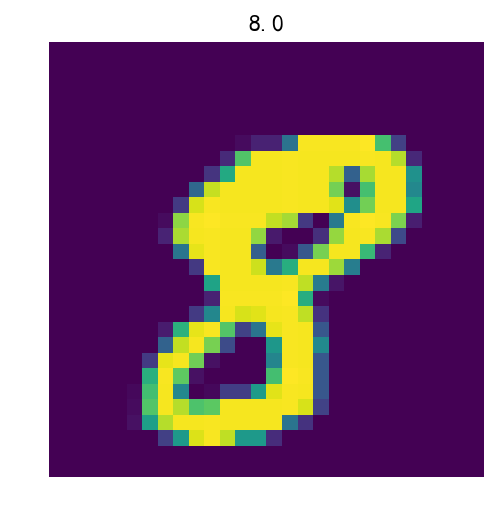

In [14]:
# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28, 28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
# lt.savefig('graph.png')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

features_train, features_test, targets_train, targets_test = train_test_split(
    features_numpy, targets_numpy, test_size=0.2, random_state=42)

In [7]:
import torch

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)  # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)  # data type is long

In [8]:
# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

In [12]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain, targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest, targetsTest)

In [13]:
# data loader
train_loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
    test, batch_size=batch_size, shuffle=False)

In [15]:
import torch.nn as nn


# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        # There should be logistic function right?
        # However logistic function in pytorch is in loss function
        # So actually we do not forget to put it, it is only at next parts

    def forward(self, x):
        out = self.linear(x)
        return out


# Instantiate Model Class
input_dim = 28 * 28  # size of image px*px
output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9

# create logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)

# Cross Entropy Loss
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Define variables
        train = images.view(-1, 28 * 28)
        labels = labels

        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(train)

        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)

        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        count += 1

        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:
                test = images.view(-1, 28 * 28)

                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(
                count, loss.data, accuracy))

Iteration: 500  Loss: 1.8452650308609009  Accuracy: 65%
Iteration: 1000  Loss: 1.6276496648788452  Accuracy: 73%
Iteration: 1500  Loss: 1.3116974830627441  Accuracy: 77%
Iteration: 2000  Loss: 1.1948779821395874  Accuracy: 79%
Iteration: 2500  Loss: 1.042231559753418  Accuracy: 80%
Iteration: 3000  Loss: 0.9462909698486328  Accuracy: 81%
Iteration: 3500  Loss: 0.9080336689949036  Accuracy: 82%
Iteration: 4000  Loss: 0.7463043928146362  Accuracy: 82%
Iteration: 4500  Loss: 0.9675344824790955  Accuracy: 83%
Iteration: 5000  Loss: 0.8043452501296997  Accuracy: 83%
Iteration: 5500  Loss: 0.7523790597915649  Accuracy: 83%
Iteration: 6000  Loss: 0.8715217709541321  Accuracy: 84%
Iteration: 6500  Loss: 0.6544672250747681  Accuracy: 84%
Iteration: 7000  Loss: 0.7161709666252136  Accuracy: 84%
Iteration: 7500  Loss: 0.6387426853179932  Accuracy: 85%
Iteration: 8000  Loss: 0.7430320978164673  Accuracy: 85%
Iteration: 8500  Loss: 0.5495306253433228  Accuracy: 85%
Iteration: 9000  Loss: 0.66458845

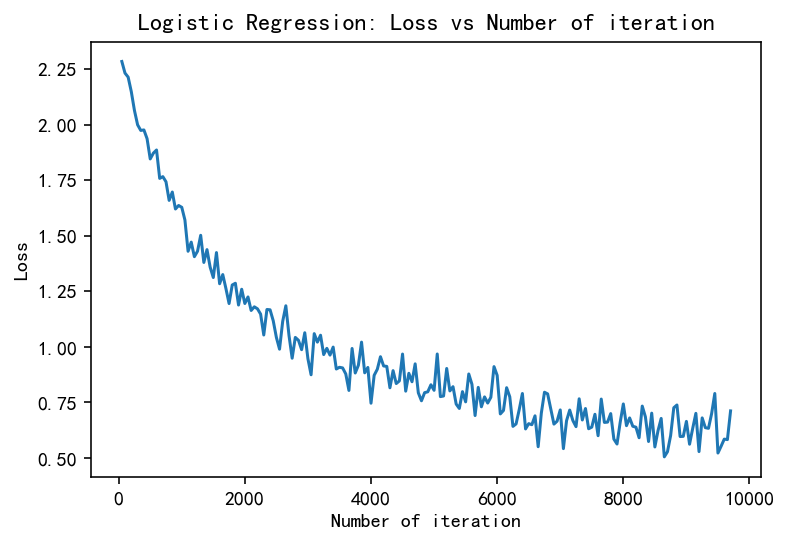

In [18]:
# visualization
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()

## 人工神经网络

In [19]:
# Create ANN Model
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()

        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()

        # Linear function 4 (readout): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)

        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)

        # Linear function 4 (readout)
        out = self.fc4(out)
        return out


# instantiate ANN
input_dim = 28 * 28
hidden_dim = 150  #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = images.view(-1, 28 * 28)
        labels = labels

        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(train)

        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)

        # Calculating gradients
        loss.backward()

        # Update parameters
        optimizer.step()

        count += 1

        if count % 50 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:

                test = images.view(-1, 28 * 28)

                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(
                    count, loss.item(), accuracy))

Iteration: 500  Loss: 0.4080701470375061  Accuracy: 88 %
Iteration: 1000  Loss: 0.33227798342704773  Accuracy: 89 %
Iteration: 1500  Loss: 0.16268111765384674  Accuracy: 90 %
Iteration: 2000  Loss: 0.25610315799713135  Accuracy: 91 %
Iteration: 2500  Loss: 0.2522209882736206  Accuracy: 92 %
Iteration: 3000  Loss: 0.10643023252487183  Accuracy: 93 %
Iteration: 3500  Loss: 0.22091583907604218  Accuracy: 94 %
Iteration: 4000  Loss: 0.052896760404109955  Accuracy: 94 %
Iteration: 4500  Loss: 0.2585967779159546  Accuracy: 94 %
Iteration: 5000  Loss: 0.08457864075899124  Accuracy: 95 %
Iteration: 5500  Loss: 0.1975518763065338  Accuracy: 95 %
Iteration: 6000  Loss: 0.19650283455848694  Accuracy: 95 %
Iteration: 6500  Loss: 0.09687969088554382  Accuracy: 95 %
Iteration: 7000  Loss: 0.09952685981988907  Accuracy: 96 %
Iteration: 7500  Loss: 0.09998035430908203  Accuracy: 96 %
Iteration: 8000  Loss: 0.1625431478023529  Accuracy: 96 %
Iteration: 8500  Loss: 0.07444793730974197  Accuracy: 96 %
It

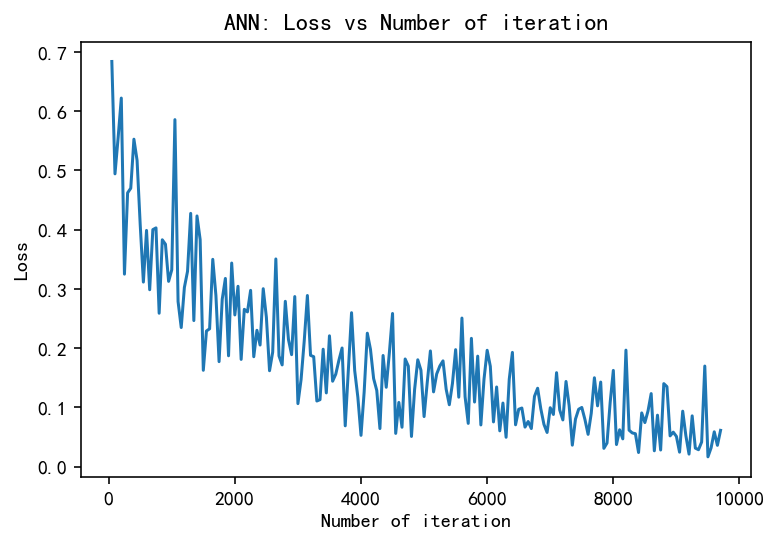

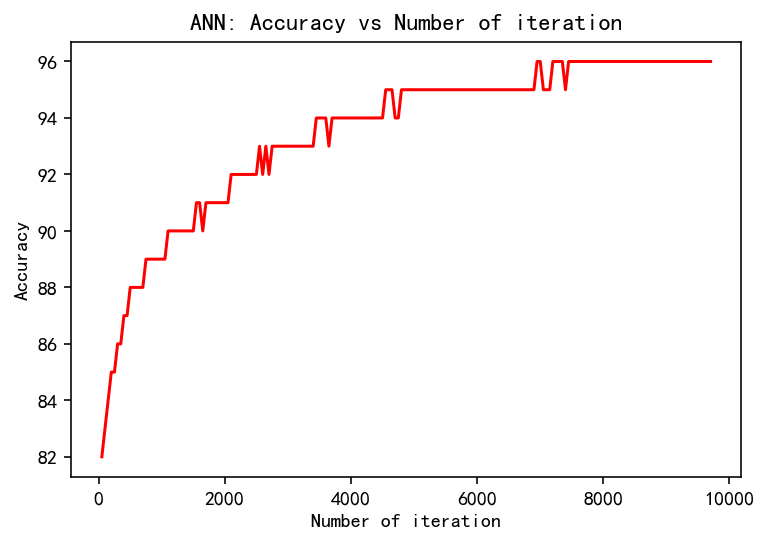

In [23]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

## CNN

In [24]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create ANN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = images.view(100, 1, 28, 28)
        labels = labels

        # Clear gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(train)

        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)

        # Calculating gradients
        loss.backward()

        # Update parameters
        optimizer.step()
        count += 1
        if count % 50 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:

                test = images.view(100, 1, 28, 28)

                # Forward propagation
                outputs = model(test)

                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]

                # Total number of labels
                total += len(labels)

                correct += (predicted == labels).sum()

            accuracy = 100 * correct / float(total)

            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(
                    count, loss.item(), accuracy))

Iteration: 500  Loss: 0.12367846816778183  Accuracy: 96 %
Iteration: 1000  Loss: 0.032468486577272415  Accuracy: 97 %
Iteration: 1500  Loss: 0.028592240065336227  Accuracy: 97 %
Iteration: 2000  Loss: 0.014295000582933426  Accuracy: 98 %


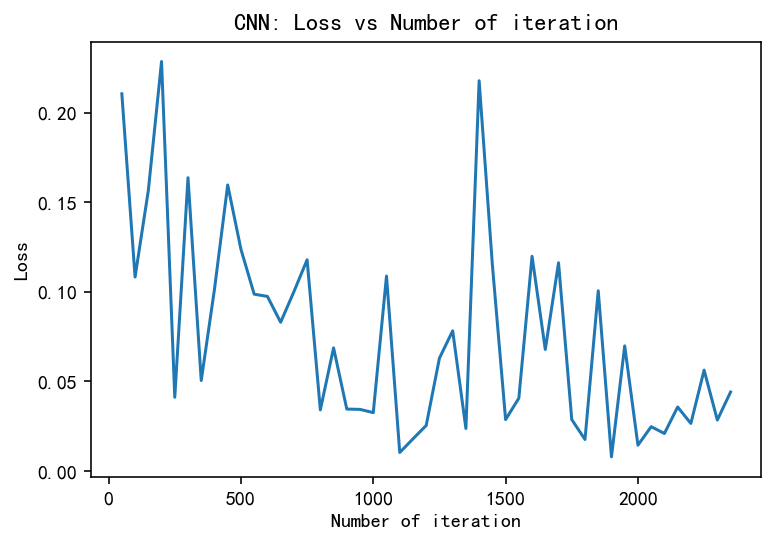

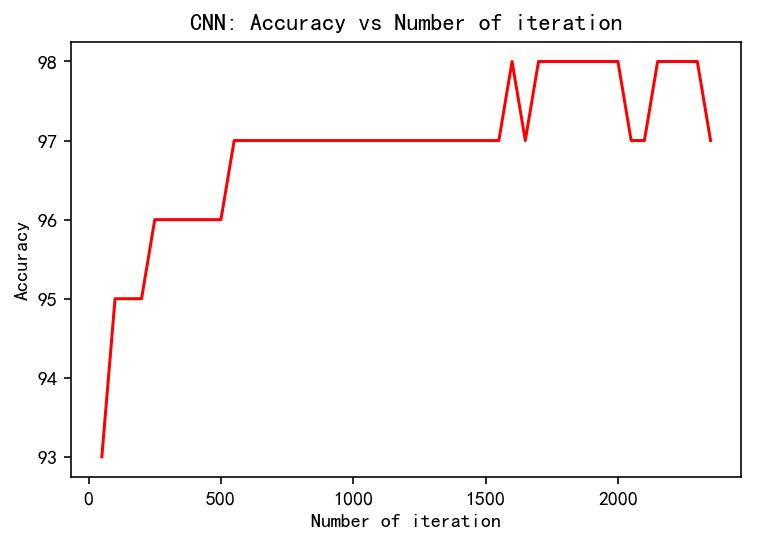

In [27]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()